## Preparing our Workspace

We load in the modules we will need.

In [2]:
import pandas as pd
import statsmodels.api as sm
import pylab as pi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


We load in the data and assign it to the variable df

In [4]:
df = pd.read_csv("../assets/admissions.csv", names=("admit","gre","gpa","prestige"))
df.head()

,admit,gre,gpa,prestige
0,admit,gre,gpa,prestige
1,0,380,3.61,3
2,1,660,3.67,3
3,1,800,4,1
4,1,640,3.19,4


We remove the header row by slicing the data and assigning back to the variable df

In [5]:
df = df[1:]

We publish some outline statistics for the data, to get a quick look at whether there are any missing values.

## Parsing Data

We take a look at the value types (dtypes) in each column.  As the data has been loaded in as a series of objects, we really want them to be arrays so we can manipulate them, vectorize them, broadcast functions.  So we'll change the dtypes in the following cells.

In [13]:
df.describe()

,admit,gre,gpa
count,400.000000,400.000000,398.00000
mean,0.317500,585.100000,3.39093
std,0.466087,122.586944,0.38063
min,0.000000,0.000000,2.26000
25%,0.000000,515.000000,3.13000
50%,0.000000,580.000000,3.39500
75%,1.000000,660.000000,3.67000
max,1.000000,800.000000,4.00000


It looks like we have two NANs in the GPA column, which bear further investigation.  So let's fish them out.

In [38]:
nans = lambda df: df[df.isnull().any(axis=1)]

In [39]:
nans(df)

,admit,gre,gpa,prestige
188,0,0,NaN,2
237,1,660,NaN,NaN


Individual represented in record at Index 188 has not been admitted, has no GRE and their GPA is not a number.  

Similarly, there is incomplete data for the individual at index 237.  

With regard to these records, they are not outliers but seemingly incomplete data.  Therefore, we will use the pandas built-in method to fill the missing values with series mean data in order to homogenise the sample. 

However, before we fill the nans, we will save the df as a new df so that we can revert should we need to when we come to further analysis later in the process.

In [40]:
df1 = df.fillna(df.mean())

The steps we have taken have had only a very modest effect upon the data and have improved its integrity for the purposes of exploratory data analysis.  

In [42]:
df1.describe()

,admit,gre,gpa
count,400.000000,400.000000,400.000000
mean,0.317500,585.100000,3.390930
std,0.466087,122.586944,0.379675
min,0.000000,0.000000,2.260000
25%,0.000000,515.000000,3.130000
50%,0.000000,580.000000,3.390930
75%,1.000000,660.000000,3.670000
max,1.000000,800.000000,4.000000


In [43]:
df1.dtypes

admit         int64
gre           int64
gpa         float64
prestige     object
dtype: object

In [44]:
df1['admit'] = df.admit.values.astype(int)
df1['gre'] = df.gre.values.astype(int)
df1['gpa'] = df.gpa.values.astype(float)

In [45]:
df1['prestige'].value_counts()

2    150
3    121
4     67
1     61
Name: prestige, dtype: int64

In [46]:
df1['admit'].value_counts()

0    273
1    127
Name: admit, dtype: int64

In [88]:
no_gre = df1['gre'] == 0
no_gre.value_counts()

False    398
True       2
Name: gre, dtype: int64

In [47]:
df.std()

admit      0.466087
gre      122.586944
gpa        0.380630
dtype: float64

# Exploratory Graphical Analysis

Let's run some initial graphical exploratory data analysis to get a feel for the data.  We will construct swarmplots of each of the main indices versus admission to seek to establish any correlation.  

### Admission vs GRE

Plotting admission vs GRE on a swarmplot (charting in effect a cumulative distribution of each GRE score against admission) suggests the following:

* as one would expect, more people applied to UCLA than got in
* generally, those with marginally higher scores were more successful as applicants (correlation) but what is striking is that the shape of each two distributions is similar
* a lower GRE does not appear to be a barrier to entry to UCLA to individuals, suggesting that other factors, or combinations of factors may play a role

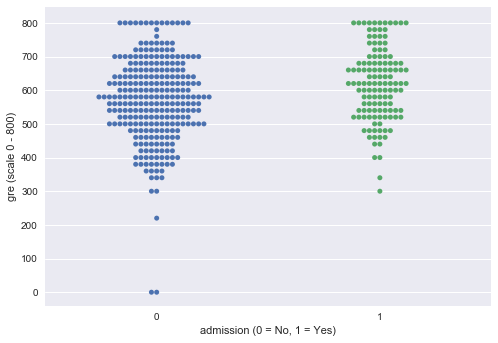

In [16]:
_ = sns.swarmplot(x = df['admit'], y = df['gre'], data = df)
_ = plt.xlabel('admission (0 = No, 1 = Yes)')
_ = plt.ylabel('gre (scale 0 - 800)')
plt.show()

### Admission vs prestige

Plotting admission vs prestige on a swarmplot will be challenging because prestige is scored on a scale of four categories.  Instead, we will use a pivot table to chart the distribution of values.  We see from the below pivot table that charts the prestige of a student's alma mater versus whether or not they were admitted to UCLA that:

* of successful applicants, more went to the top two categories of 'prestigious schools' than not
* of unsuccessful applicants, more went to the 2nd and 3rd tier prestige schools than the top and bottom schools
* there appears to be some correlation between school standard and admission
* this is worthy of further probing

In [51]:
prestige_pivot = pd.crosstab(df1['admit'], df1['prestige'], rownames=['admit'])
prestige_pivot

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,53,28,12


### General Overview of Distributions of Data

Plotting histograms of the data distributions suggest that the gpa and gre distributions show negative skew as predicted at the outset in our problem statement.  This is to be expected given the somewhat self-selecting nature of the sample (we would expect applicants to have higher GRE and GPA than say the population of the US on average[1]). There are some quite low values in the gre column that suggest they may be potential outliers, similarly in the gpa column, but it is difficult to determine by graphical analysis alone whether they are clerical error or otherwise, or whether they represent individuals applying to UCLA on a 'nothing ventured, nothing gained' basis.

Looking back to the outline statistics set out above, the lowest value in the GRE column is '0' which suggests someone has perhaps not taken the GRE and applied.  This is plausible. 

Given the binary nature of the dummified prestige columns (see below for more on collinearity), the histograms are more useful here as a binary classifier than anything.  Similarly in the case of the admit column's relevant histogram. 

[1]not to be confused with the population from which this sample would be drawn in the case of repeated analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114c1a4d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11446ea50>]], dtype=object)

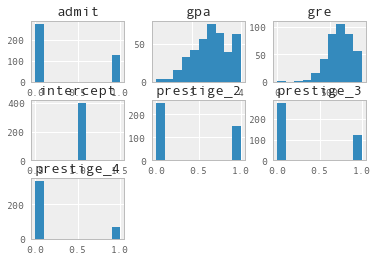

In [76]:
data.hist()

For the purposes of logistic regression, we will favour splitting out the prestige column into four separate columns with binary indicator 'dummy' variables, using the get_dummies method.  The purpose of doing this is to guard against the scenario in which there is collinearity between the prestige column entries (since an absence of the best school predicts the presence of one of the other school ranks and so forth).

When we get to the regression exercise, we exclude one of the columns on purpose with a view to removing this collinearity.  The value left out (the least prestigious schools) in this case can be thought of as the reference value and the fit values of the remaining categories represent the change from this reference.

In [55]:
dummy_ranks = pd.get_dummies(df1['prestige'], prefix='prestige')

In [56]:
print dummy_ranks.head()

   prestige_1  prestige_2  prestige_3  prestige_4
1           0           0           1           0
2           0           0           1           0
3           1           0           0           0
4           0           0           0           1
5           0           0           0           1


In [64]:
# we create a list of columns we want to retain
cols_to_retain = ['admit','gre','gpa']
#we join the columns we want to retain from the datafram
# to the dummified column but hold one column in order to hold back one model to guard against
# the dummy variable trap, and avoid perfect multicollinearity among the prestige variables
data = df1[cols_to_retain].join(dummy_ranks.loc[:, 'prestige_2':])

In [65]:
data['intercept'] = 1.0 #we add the intercept which is our constant, which the statsmodels function requires
# to be stated explicitly

In [66]:
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
1,0,380,3.61,0,1,0,1.0
2,1,660,3.67,0,1,0,1.0
3,1,800,4.00,0,0,0,1.0
4,1,640,3.19,0,0,1,1.0
5,0,520,2.93,0,0,1,1.0


In [96]:
data.tail()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
396,0,620,4.00,1,0,0,1.0
397,0,560,3.04,0,1,0,1.0
398,0,460,2.63,1,0,0,1.0
399,0,700,3.65,1,0,0,1.0
400,0,600,3.89,0,1,0,1.0


# Performing the Logistic Regression

We specify the columns containing the variable we're trying to predict followed by the columns that the model should use to make the prediction.

In our case, we'll be predicting the admit column using the gre, gpa, prestige_2, prestige_3 and prestige_4 columns.  Prestige_1 is held back as a baseline and to prevent multi-collinearity.

In [111]:
train_cols = data.columns[1:]

In [107]:
data['prestige_2'] = data.prestige_2.values.astype(int)
data['prestige_3'] = data.prestige_3.values.astype(int)
data['prestige_4'] = data.prestige_4.values.astype(int)

In [112]:
data.dtypes

admit           int64
gre             int64
gpa           float64
prestige_2      int64
prestige_3      int64
prestige_4      int64
intercept     float64
dtype: object

In [123]:
logit = sm.Logit(data['admit'], data[train_cols])

The first time we called the logit function, it threw an error, so in the interests of tranparency, we traced back to the beginning and established that not all the Nans were filled in the dataframe initially. This was then effected.

In [119]:
nans = lambda data: data[data.isnull().any(axis=1)]

In [117]:
data = data.fillna(data.mean())

In [124]:
nans(data) #successfully cleared the Nans

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept


In [122]:
data.describe()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.0
mean,0.317500,585.100000,3.390930,0.375000,0.302500,0.167500,1.0
std,0.466087,122.586944,0.379675,0.484729,0.459916,0.373889,0.0
min,0.000000,0.000000,2.260000,0.000000,0.000000,0.000000,1.0
25%,0.000000,515.000000,3.130000,0.000000,0.000000,0.000000,1.0
50%,0.000000,580.000000,3.390930,0.000000,0.000000,0.000000,1.0
75%,1.000000,660.000000,3.670000,1.000000,1.000000,0.000000,1.0
max,1.000000,800.000000,4.000000,1.000000,1.000000,1.000000,1.0


In [125]:
#now to fit the logistic regression model

result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.571540
         Iterations 6


# The Results and Interpretation

The results connote that there is an inversely proportional relationship between the probability of being admitted to UCLA and the prestige fo the candidate's undergraduate school.  The probability of admittance is higher for students that attended a top-ranked undergraduate college (prestige_1 == 1) compared to a lower-ranked school.  Remember that the prestige is reverse-scored.

Our null hypothesis was that the predictor variables would have no effect upon admittance to UCLA.  

In [126]:
print result.summary()

                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Sun, 02 Jul 2017   Pseudo R-squ.:                 0.08549
Time:                        19:49:52   Log-Likelihood:                -228.62
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 4.162e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0024      0.001      2.254      0.024       0.000       0.004
gpa            0.7641      0.332      2.302      0.021       0.114       1.415
prestige_2    -0.7167      0.315     -2.272      0.0

In [127]:
print result.conf_int() #let's look at the confidence interval of each coefficient

                   0         1
gre         0.000311  0.004462
gpa         0.113583  1.414672
prestige_2 -1.335051 -0.098348
prestige_3 -2.040415 -0.692707
prestige_4 -2.398481 -0.765520
intercept  -6.128098 -1.665317


In [129]:
print np.exp(result.params) #let's look at odds ratios

gre           1.002390
gpa           2.147121
prestige_2    0.488361
prestige_3    0.254982
prestige_4    0.205563
intercept     0.020309
dtype: float64


# Visualising the Results



In [49]:
admission = df1['admit']
prestige = df1['prestige']
gre = df1['gre']
gpa = df1['gpa']